In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 32
learning_rate  = 1e-2
momentum = 0.5
epochs = 100

In [3]:
train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transforms.Compose([
                                transforms.Resize([256, 256]),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),                       # 数据类型转化
                                transforms.Normalize(
                                    (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # 数据归一化处理
                            ]))

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                           ]))

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, **kwargs):
        super(BasicBlock, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, **kwargs),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
            
    def forward(self, x):
        out = self.feature(x)  
        return out

In [7]:
class Inception(nn.Module):
    def __init__(self, in_channel, out_channel1, temp_channel2, out_channel2, temp_channel3, out_channel3, out_channel4):
        super(Inception, self).__init__()
        self.branch1 = BasicBlock(in_channel=in_channel,
                                  out_channel=out_channel1, kernel_size=1)
        self.branch2 = nn.Sequential(
            BasicBlock(in_channel=in_channel,
                       out_channel=temp_channel2, kernel_size=1),
            BasicBlock(in_channel=temp_channel2,
                       out_channel=out_channel2, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            BasicBlock(in_channel=in_channel,
                       out_channel=temp_channel3, kernel_size=1),
            BasicBlock(in_channel=temp_channel3,
                       out_channel=out_channel3, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicBlock(in_channel=in_channel,
                       out_channel=out_channel4, kernel_size=1),
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

In [8]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        # input [batch,3,224,224] -> [batch,64,56,56]
        self.Inception1 = nn.Sequential(
            BasicBlock(in_channel=3, out_channel=64,
                          kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        # input [batch,64,56,56] -> [batch,192,28,28]
        self.Inception2 = nn.Sequential(
            BasicBlock(in_channel=64, out_channel=64, kernel_size=1),
            BasicBlock(in_channel=64, out_channel=192,
                          kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # input[batch, 192, 28, 28] -> [batch, 480, 14, 14]
        self.Inception3 = nn.Sequential(
            Inception(in_channel=192, out_channel1=64, temp_channel2=96,
                      out_channel2=128, temp_channel3=16, out_channel3=32, out_channel4=32),
            Inception(in_channel=256, out_channel1=128, temp_channel2=128,
                      out_channel2=192, temp_channel3=32, out_channel3=96, out_channel4=64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # input [batch,480,14,14] -> [batch,832,7,7]
        self.Inception4 = nn.Sequential(
            Inception(in_channel=480, out_channel1=192, temp_channel2=96,
                      out_channel2=208, temp_channel3=16, out_channel3=48, out_channel4=64),
            Inception(in_channel=512, out_channel1=160, temp_channel2=112,
                      out_channel2=224, temp_channel3=24, out_channel3=64, out_channel4=64),
            Inception(in_channel=512, out_channel1=128, temp_channel2=128,
                      out_channel2=256, temp_channel3=24, out_channel3=64, out_channel4=64),
            Inception(in_channel=512, out_channel1=112, temp_channel2=114,
                      out_channel2=288, temp_channel3=32, out_channel3=64, out_channel4=64),
            Inception(in_channel=528, out_channel1=256, temp_channel2=160,
                      out_channel2=320, temp_channel3=32, out_channel3=128, out_channel4=128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # input [batch,832,7,7] -> [batch,1024,7,7]
        self.Inception5 = nn.Sequential(
            Inception(in_channel=832, out_channel1=256, temp_channel2=160,
                      out_channel2=320, temp_channel3=32, out_channel3=128, out_channel4=128),
            Inception(in_channel=832, out_channel1=384, temp_channel2=192,
                      out_channel2=384, temp_channel3=48, out_channel3=128, out_channel4=128),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1024, num_classes)
        

    def forward(self, x):
        out = self.Inception1(x)
        out = self.Inception2(out)
        out = self.Inception3(out)
        out = self.Inception4(out)
        out = self.Inception5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        return out

In [9]:
net = GoogLeNet().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.5, patience=3)

In [10]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()
        
        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(val_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [11]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    
    return val_loss, val_acc

In [12]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [13]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [14]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [15]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.279583
Train Epoch: 1 [3200/40000 (8%)]	Loss: 2.057390
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.027508
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.664644
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.906997
Train Epoch: 1 [16000/40000 (40%)]	Loss: 1.825669
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.589879
Train Epoch: 1 [22400/40000 (56%)]	Loss: 2.082232
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.732517
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.540908
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.508562
Train Epoch: 1 [35200/40000 (88%)]	Loss: 1.468545
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.179532

VAL set: Average loss: 0.0462, Accuracy: 4517.0/10000 (45.2%)

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.544149
Train Epoch: 2 [3200/40000 (8%)]	Loss: 1.149108
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.095712
Train Epoch: 2 [9600/40000 (24%)]	Loss: 1.374987
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.257869
Train Epoch: 2 [16000/40000 (40%)]	Loss: 1.367035
Trai

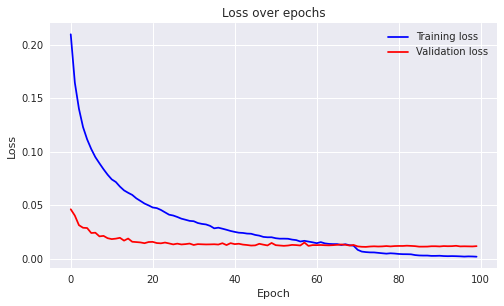

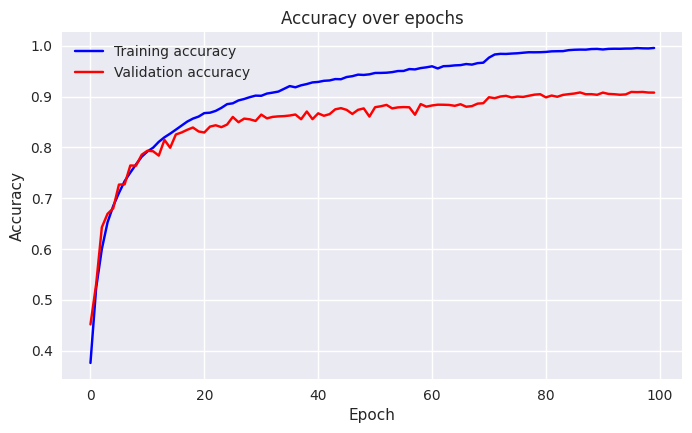

In [16]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'GoogLeNet - predictions')

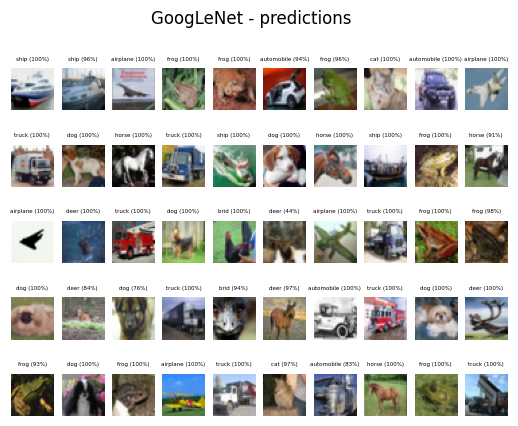

In [19]:
CIFAR_dict = {0: 'airplane',
              1: 'automobile',
              2: 'brid',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[int(torch.argmax(probs))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('GoogLeNet - predictions')


In [ ]:
"""
GooLeNet
Mine(batch_size = 32):
After 020 Epoch: 83.2%
After 040 Epoch: 85.6%
After 060 Epoch: 88.0%
After 080 Epoch: 90.5%
After 100 Epoch: 90.8%
Mine(batch_size = 64):
After 020 Epoch: 81.6%
After 040 Epoch: 85.0%
After 060 Epoch: 87.9%
After 080 Epoch: 89.1%
After 100 Epoch: 89.1%
structure:
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 112, 112]        --
|    |    └─Sequential: 3-1              [-1, 64, 112, 112]        9,600
|    └─MaxPool2d: 2-2                    [-1, 64, 56, 56]          --
|    └─BatchNorm2d: 2-3                  [-1, 64, 56, 56]          128
|    └─ReLU: 2-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-2                        [-1, 192, 28, 28]         --
|    └─BasicBlock: 2-5                   [-1, 64, 56, 56]          --
|    |    └─Sequential: 3-2              [-1, 64, 56, 56]          4,288
|    └─BasicBlock: 2-6                   [-1, 192, 56, 56]         --
|    |    └─Sequential: 3-3              [-1, 192, 56, 56]         111,168
|    └─MaxPool2d: 2-7                    [-1, 192, 28, 28]         --
├─Sequential: 1-3                        [-1, 480, 14, 14]         --
|    └─Inception: 2-8                    [-1, 256, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 64, 28, 28]          12,480
|    |    └─Sequential: 3-5              [-1, 128, 28, 28]         129,696
|    |    └─Sequential: 3-6              [-1, 32, 28, 28]          16,016
|    |    └─Sequential: 3-7              [-1, 32, 28, 28]          6,240
|    └─Inception: 2-9                    [-1, 480, 28, 28]         --
|    |    └─BasicBlock: 3-8              [-1, 128, 28, 28]         33,152
|    |    └─Sequential: 3-9              [-1, 192, 28, 28]         254,912
|    |    └─Sequential: 3-10             [-1, 96, 28, 28]          85,376
|    |    └─Sequential: 3-11             [-1, 64, 28, 28]          16,576
|    └─MaxPool2d: 2-10                   [-1, 480, 14, 14]         --
├─Sequential: 1-4                        [-1, 832, 7, 7]           --
|    └─Inception: 2-11                   [-1, 512, 14, 14]         --
|    |    └─BasicBlock: 3-12             [-1, 192, 14, 14]         92,736
|    |    └─Sequential: 3-13             [-1, 208, 14, 14]         226,704
|    |    └─Sequential: 3-14             [-1, 48, 14, 14]          27,072
|    |    └─Sequential: 3-15             [-1, 64, 14, 14]          30,912
|    └─Inception: 2-12                   [-1, 512, 14, 14]         --
|    |    └─BasicBlock: 3-16             [-1, 160, 14, 14]         82,400
|    |    └─Sequential: 3-17             [-1, 224, 14, 14]         284,144
|    |    └─Sequential: 3-18             [-1, 64, 14, 14]          50,952
|    |    └─Sequential: 3-19             [-1, 64, 14, 14]          32,960
|    └─Inception: 2-13                   [-1, 512, 14, 14]         --
|    |    └─BasicBlock: 3-20             [-1, 128, 14, 14]         65,920
|    |    └─Sequential: 3-21             [-1, 256, 14, 14]         361,600
|    |    └─Sequential: 3-22             [-1, 64, 14, 14]          50,952
|    |    └─Sequential: 3-23             [-1, 64, 14, 14]          32,960
|    └─Inception: 2-14                   [-1, 528, 14, 14]         --
|    |    └─BasicBlock: 3-24             [-1, 112, 14, 14]         57,680
|    |    └─Sequential: 3-25             [-1, 288, 14, 14]         355,062
|    |    └─Sequential: 3-26             [-1, 64, 14, 14]          67,872
|    |    └─Sequential: 3-27             [-1, 64, 14, 14]          32,960
|    └─Inception: 2-15                   [-1, 832, 14, 14]         --
|    |    └─BasicBlock: 3-28             [-1, 256, 14, 14]         135,936
|    |    └─Sequential: 3-29             [-1, 320, 14, 14]         546,720
|    |    └─Sequential: 3-30             [-1, 128, 14, 14]         119,776
|    |    └─Sequential: 3-31             [-1, 128, 14, 14]         67,968
|    └─MaxPool2d: 2-16                   [-1, 832, 7, 7]           --
├─Sequential: 1-5                        [-1, 1024, 7, 7]          --
|    └─Inception: 2-17                   [-1, 832, 7, 7]           --
|    |    └─BasicBlock: 3-32             [-1, 256, 7, 7]           213,760
|    |    └─Sequential: 3-33             [-1, 320, 7, 7]           595,360
|    |    └─Sequential: 3-34             [-1, 128, 7, 7]           129,504
|    |    └─Sequential: 3-35             [-1, 128, 7, 7]           106,880
|    └─Inception: 2-18                   [-1, 1024, 7, 7]          --
|    |    └─BasicBlock: 3-36             [-1, 384, 7, 7]           320,640
|    |    └─Sequential: 3-37             [-1, 384, 7, 7]           825,024
|    |    └─Sequential: 3-38             [-1, 128, 7, 7]           194,064
|    |    └─Sequential: 3-39             [-1, 128, 7, 7]           106,880
├─AdaptiveAvgPool2d: 1-6                 [-1, 1024, 1, 1]          --
├─Dropout: 1-7                           [-1, 1024]                --
├─Linear: 1-8                            [-1, 10]                  10,250
==========================================================================================
Total params: 5,905,280
Trainable params: 5,905,280
Non-trainable params: 0
Total mult-adds (M): 501.08
==========================================================================================
Input size (MB): 0.57
Forward/backward pass size (MB): 26.03
Params size (MB): 22.53
Estimated Total Size (MB): 49.13
==========================================================================================
parameters_count: 5905280
"""